In [169]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df
from stage_predict import stage_score_plot

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)

In [4]:
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [5]:
bill_text_df_new = prepare_bill_text_for_clean_df(bill_text_df)

In [6]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
        
    def remove_neg(num):
        if num < 0:
            return 0
        else: return num
        
    def count_sections(bill_text):
        sections = []
        for count in range(1, 20):
            section_indicator = '({})'.format(count)
            if section_indicator in bill_text:
                sections.append(count)
        if len(sections) == 0:
            return 0
        return np.max(sections)
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['num_sections'] = clean['bill_text'].apply(count_sections)
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])
    clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']
    clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)
    
    return clean

In [7]:
clean = create_clean_X(merged_final_df, bill_text_df_new, rep_score_df)

In [8]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0


In [ ]:
# def flip_vote(vote):
#     if vote == 1:
#         return 0
#     if vote == 0:
#         return 1
#     else:
#         return vote

In [ ]:
# clean['vote'] = clean['vote'].apply(flip_vote)

### Dummies

In [ ]:
# clean_new = clean.copy()

In [ ]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

# voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
# clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [138]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,num_sections
1911193,1,2007-03-09,1887,0,2007-08 HB 1371,62764.0,2007-08,HB 1371,http://app.leg.wa.gov/documents/billdocs/2007-...,0,...,10031,0.000000,1.000000,15347,17,1,2007,2007.0,0.0,9
2083165,0,2007-04-05,10249,0,2007-08 SB 5134,66962.0,2007-08,SB 5134,http://app.leg.wa.gov/documents/billdocs/2007-...,1,...,174,0.500000,0.500000,3794,17,5,2007,2007.0,0.0,4
1845660,1,2006-03-03,972,0,2005-06 E2SSB 6239,60463.0,2005-06,E2SSB 6239,http://app.leg.wa.gov/documents/billdocs/2005-...,1,...,171,0.666667,0.333333,72683,15,7,2006,2006.0,0.0,19
1708539,1,2005-04-06,516,1,2005-06 SHB 1951,55411.0,2005-06,SHB 1951,http://app.leg.wa.gov/documents/billdocs/2005-...,0,...,649,0.444444,0.555556,2151,15,9,2005,2005.0,0.0,5
1459538,0,2004-02-16,2159,0,2003-04 2EHB 1926,47385.0,2003-04,2EHB 1926,http://app.leg.wa.gov/documents/billdocs/2003-...,0,...,2159,0.000000,1.000000,4521,13,16,2004,2003.0,1.0,4


In [139]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [140]:
loyalty_scores_df = create_loyalty_scores_df(sample_train)

In [141]:
# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

In [142]:
sample_train = sample_train.drop('index', axis=1)

In [143]:
loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

In [144]:
yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

In [145]:
loy_dem_average, loy_rep_average

(0.24607516350896885, -0.17506061436930442)

In [146]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

In [147]:
sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [148]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

In [149]:
def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

In [150]:
sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

In [151]:
sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,num_sections,loyalty_score,percent_yea
0,1,2018-01-11,3487,0,2017-18 HB 1452,100805.0,2017-18,HB 1452,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.500000,20562,27,11,2018,2017.0,1.0,11,0.383604,0.931783
1,0,2018-02-09,15820,0,2017-18 2SHB 1377,100640.0,2017-18,2SHB 1377,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,12211,27,15,2018,2018.0,0.0,5,-0.382451,0.758065
2,1,2018-01-18,1543,0,2017-18 HB 1640,101249.0,2017-18,HB 1640,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.666667,5397,27,5,2018,2017.0,1.0,3,0.247165,0.907654
3,1,2018-02-13,15822,0,2017-18 HB 2611,102998.0,2017-18,HB 2611,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.083333,10612,27,15,2018,2018.0,0.0,14,-0.361529,0.808564
4,1,2018-02-09,15779,1,2017-18 SB 6039,105825.0,2017-18,SB 6039,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.500000,3631,27,4,2018,2018.0,0.0,7,-0.076313,0.954301
5,1,2018-02-12,14211,0,2017-18 SHB 1558,101071.0,2017-18,SHB 1558,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.736842,14555,27,24,2018,2018.0,0.0,19,-0.380681,0.861386
6,1,2018-03-03,10041,0,2017-18 2ESHB 2057,102062.0,2017-18,2ESHB 2057,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,86739,27,1,2018,2017.0,1.0,18,-0.416644,0.784464
7,1,2018-03-05,5154,0,2017-18 EHB 2097,102116.0,2017-18,EHB 2097,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,3858,27,20,2018,2017.0,1.0,3,0.388704,0.931222
8,1,2018-03-07,11999,0,2017-18 E2SHB 1054,99951.0,2017-18,E2SHB 1054,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.757576,18701,27,40,2018,2018.0,0.0,19,0.426204,0.941482
9,1,2018-02-08,18546,0,2017-18 E2SHB 1622,101217.0,2017-18,E2SHB 1622,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,25582,27,7,2018,2018.0,0.0,9,0.241930,0.960784


### Only 2017-18

In [ ]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

In [ ]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [ ]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

# Modeling

### Baseline Model

In [ ]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [ ]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [ ]:
y_pred_b.max()

In [ ]:
log_loss(y_test_b, y_pred_b)

In [ ]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [160]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections']]

y_test_t = sample_test['vote']

In [161]:
top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [162]:
log_loss(y_test_t, y_pred_t)

0.3564759558477197

In [163]:
y_pred_t.min()

0.4144567823339065

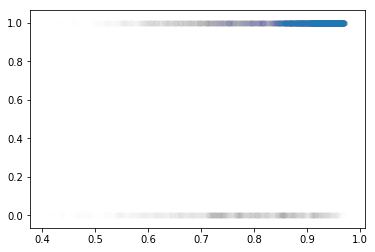

In [164]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.005)

In [165]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [166]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.7853622247801915

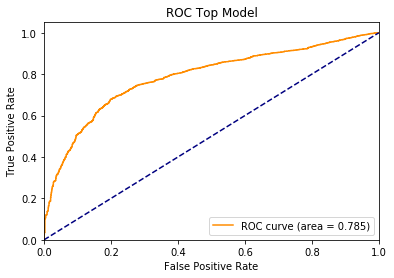

In [167]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### Trying out new model

In [34]:
# TRAIN
X_train_n = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea']]

y_train_n = sample_train['vote']

# TEST
X_test_n = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea']]

y_test_n = sample_test['vote']

In [57]:
new_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, max_depth=9, random_state=709, 
                                       verbose=1)
new_model.fit(X_train_t, y_train_t)
y_pred_n = (new_model.predict_proba(X_test_n))[:, 1]

      Iter       Train Loss   Remaining Time 
         1           0.6402           47.16m
         2           0.6373           45.20m
         3           0.6345           44.94m
         4           0.6317           44.84m
         5           0.6291           45.19m
         6           0.6266           45.53m
         7           0.6242           45.66m
         8           0.6219           45.70m
         9           0.6196           45.58m
        10           0.6174           45.56m
        20           0.5983           46.29m
        30           0.5833           46.01m
        40           0.5704           45.58m
        50           0.5596           45.27m
        60           0.5505           45.07m
        70           0.5427           44.94m
        80           0.5358           45.45m
        90           0.5297           45.56m
       100           0.5245           45.26m
       200           0.4864           40.46m
       300           0.4644           34.80m
       40

In [58]:
log_loss(y_test_n, y_pred_n)

0.38189527617473645

In [59]:
y_pred_n.min()

0.08251224936894552

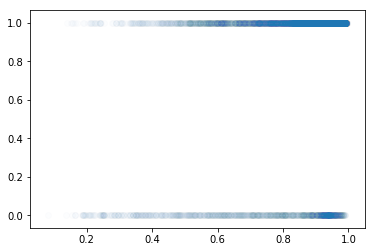

In [60]:
fig, ax = plt.subplots()
ax.scatter(y_pred_n, y_test_n, alpha=0.01)

In [61]:
fpr_n, tpr_n, thresholds_n = roc_curve(y_test_n, y_pred_n)

In [62]:
roc_auc_n = roc_auc_score(y_test_n, y_pred_n)
roc_auc_n

0.7742320820585312

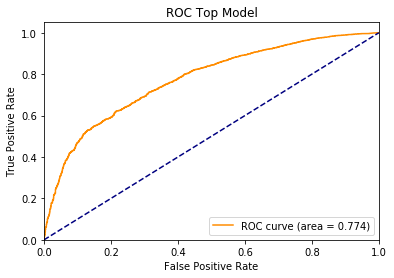

In [63]:
fig, ax = plt.subplots()
plt.plot(fpr_n, tpr_n, color='darkorange', label= f'ROC curve (area = {round(roc_auc_n, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
new_model.fit(X_train, y_train)
stage_score_plot(gdbr_model, X_train, y_train, X_test, y_test)
stage_score_plot(gdbr_model_2, X_train, y_train, X_test, y_test)
ax.legend()
plt.show()

### NLP Playground

In [ ]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [ ]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [ ]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [ ]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [ ]:
topic_df = topic_df.drop('biennium', axis=1)

In [ ]:
MERGD = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGD_train = MERGD[MERGD['bill_id_y'].notnull()]

In [ ]:
MERGD_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGD_test = MERGD_test[MERGD_test['bill_id_y'].notnull()]

In [ ]:
MERGD_train.columns

In [ ]:
# X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
#                      'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
#                      'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
#                      'num_sponsors', 'years_until_vote']]

In [ ]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x', 'bill_id_y', 'htm_url',
                            'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                            'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                             axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x','bill_id_y', 'htm_url',
                          'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                          'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                           axis=1)

y_test = MERGD_test['vote']

In [ ]:
model = RandomForestClassifier(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted[0:20]

In [ ]:
group = sample_train.groupby('vote')

In [ ]:
group.mean()

# Model to Pickle

# Explore bill_text

In [64]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
3097375,1,2018-03-01,1659,0,2017-18 SHB 2998,103639.0,2017-18,SHB 2998,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{15817,1543,9207,15816,18265}",18265,0.00,1.00,3180,27,7,2018,2018.0,0.0
881032,1,1998-02-10,1585,0,1997-98 SHB 2672,25621.0,1997-98,SHB 2672,http://app.leg.wa.gov/documents/billdocs/1997-...,0,...,"{2153,2174,1592,406,382,1594}",1594,0.50,0.50,1667,7,7,1998,1998.0,0.0
3151171,1,2018-02-27,13198,0,2017-18 SSB 5996,105726.0,2017-18,SSB 5996,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,5156,12003,12002,15821,27290,21520,...",1950,0.00,1.00,2548,27,12,2018,2018.0,0.0
2432392,1,2011-03-03,1659,0,2011-12 HB 1178,79451.0,2011-12,HB 1178,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,"{3478,10031}",10031,0.25,0.75,13506,21,3,2011,2011.0,0.0
1670454,1,2005-03-11,972,0,2005-06 SHB 1394,54299.0,2005-06,SHB 1394,http://app.leg.wa.gov/documents/billdocs/2005-...,0,...,"{2314,2166,8237,972}",972,0.25,0.75,12451,15,5,2005,2005.0,0.0


In [65]:
nays.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
2997634,0,2018-02-27,17217,1,2017-18 EHB 1237,100330.0,2017-18,EHB 1237,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{18057,9207,17307,10031,3483,16462,17224,10039...",9997,0.095238,0.904762,12836,27,25,2018,2017.0,1.0
3151895,0,2018-02-27,15809,0,2017-18 ESSB 6002,105739.0,2017-18,ESSB 6002,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,14325,17226,27211,14074,13546,12003...",27290,0.000000,1.000000,32142,27,25,2018,2018.0,0.0
1376648,0,2001-03-13,633,1,2001-02 SSB 5965,43637.0,2001-02,SSB 5965,http://app.leg.wa.gov/documents/billdocs/2001-...,1,...,"{2153,2304,644,347,409}",409,0.000000,1.000000,3761,11,6,2001,2001.0,0.0
2394363,0,2010-03-05,9550,0,2009-10 ESSB 6444,78003.0,2009-10,ESSB 6444,http://app.leg.wa.gov/documents/billdocs/2009-...,1,...,"{8214,337}",337,0.250000,0.750000,744659,19,3,2010,2010.0,0.0
2235843,0,2009-03-09,3478,0,2009-10 ESHB 1939,72569.0,2009-10,ESHB 1939,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,"{12084,9997,2166,9207,8420,2144,10039,8212,347...",10249,0.214286,0.785714,19888,19,16,2009,2009.0,0.0


In [ ]:
Read first time
BE IT ENACTED
AN ACT

Passed the house

In [67]:
print(yeas.loc[3097375, 'bill_text'])

 to providing a business and occupation tax exemption for accountable communities of health; adding a new section to chapter 82.04 rcw; creating new sections; and declaring an emergency.be it enacted by the legislature of the state of washington:new section.  sec. 1.  (1) this section is the tax preference performance statement for the tax preference contained in section 2, chapter . . ., laws of 2018 (section 2 of this act). the performance statement is only intended to be used for subsequent evaluation of the tax preference. it is not intended to create a private right of action by any party or be used to determine eligibility for preferential tax treatment.(2) the legislature categorizes this tax preference as one intended to reduce structural inefficiencies in the tax structure under rcw 82.32.808(2)(d).(3) the legislature acknowledges the importance of accountable communities of health under rcw 41.05.800 in aligning actions to achieve healthy communities and populations, improvin

In [68]:
print(nays.loc[2235843, 'bill_text'])

 to vehicle dealer documentary service fees; and amending rcw 46.70.180.be it enacted by the legislature of the state of washington:sec. 1 rcw 46.70.180 and 2007 c 155 s 2 are each amended to read as follows:     each of the following acts or practices is unlawful:     (1) to cause or permit to be advertised, printed, displayed, published, distributed, broadcasted, televised, or disseminated in any manner whatsoever, any statement or representation with regard to the sale, lease, or financing of a vehicle which is false, deceptive, or misleading, including but not limited to the following:     (a) that no down payment is required in connection with the sale of a vehicle when a down payment is in fact required, or that a vehicle may be purchased for a smaller down payment than is actually required;     (b) that a certain percentage of the sale price of a vehicle may be financed when such financing is not offered in a single document evidencing the entire security transaction;     (c) th

In [ ]:
bill_text_df.head()

In [ ]:
bill_text_df_test

In [ ]:
example_text = yeas.loc[402049, 'bill_text']

In [ ]:
example_text = example_text.lower()

In [ ]:
(example_text.split('first time')[1])[0:20]

### TFIDFVectorizer

In [ ]:
bills = sample_one_year['bill_text']

In [ ]:
bills.shape

In [ ]:
wordnet = WordNetLemmatizer()

In [ ]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [ ]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
vocab = tf.vocabulary_
vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed = tf.transform(bills)

In [ ]:
vocab = tf.vocabulary_

In [ ]:
vocab

In [ ]:
tfidf_cols = transformed.toarray()

In [ ]:
tfidf_names = fitted.get_feature_names()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [ ]:
tfidf_df.head()

In [ ]:
tfidf_df.shape

In [ ]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [ ]:
features_importances_sorted[0:50]